### Maximum Margin with Known Expert Policy and Finite States

#### Problem Setup
Given an agent's observed optimal policy, the objective is to estimate the reward function $R(s)$ in a Markov Decision Process (MDP) such that the observed policy is optimal.

---

#### Transition Model
For an MDP with:
- $S$: number of states,
- $A$: number of actions,
- $P(s'|s,a)$: transition probabilities,
- $\gamma$: discount factor,

the observed optimal policy specifies the best action $\pi^*(s)$ for each state $s$.

---

#### Reward Estimation
The reward estimation uses the "drop in value" function, which quantifies the difference in expected value when taking a suboptimal action $a$ instead of the optimal action $\pi^*(s)$.

---

#### Drop in Value
For a given state $s$ and action $a$, the drop in value is:
$$
\Delta V(s, a) = \left[ P_{\pi^*}(s) - P(s, a) \right] V,
$$
where:
- $P_{\pi^*}(s)$: transition probabilities under the optimal policy,
- $P(s, a)$: transition probabilities for action $a$,
- $V$: value function computed as:
$$
V = \left( I - \gamma P_{\pi^*} \right)^{-1} R,
$$
with $I$ being the identity matrix.

---

#### Linear Programming Formulation
The optimization problem for estimating the rewards $R$ is formulated as:
1. **Objective**: Minimize the drop in value for suboptimal actions:
$$
\min_{R, z} \quad - \mathbf{1}^T z + \lambda \|R\|,
$$
where $z$ are slack variables ensuring constraints are met.

2. **Constraints**:
   - Enforce optimality of the observed policy:
$$
z(s) + \Delta V(s, a) R \geq 0, \quad \forall s, \forall a \neq \pi^*(s).
$$
   - Bound rewards by a maximum value:
$$
R(s) \leq R_{\text{max}}, \quad \forall s.
$$

---

#### Algorithm Steps
1. Compute $P_{\pi^*}$, the transition matrix under the optimal policy.
2. Solve the inverse matrix $\left( I - \gamma P_{\pi^*} \right)^{-1}$.
3. Formulate the linear program:
   - Variables: $R$ and $z$,
   - Constraints based on the drop in value,
   - Objective to minimize slack $z$ and regularization term.
4. Solve using a linear programming solver.
5. Compute the estimated value function $V_{\text{est}}$ using the recovered rewards $R_{\text{est}}$.

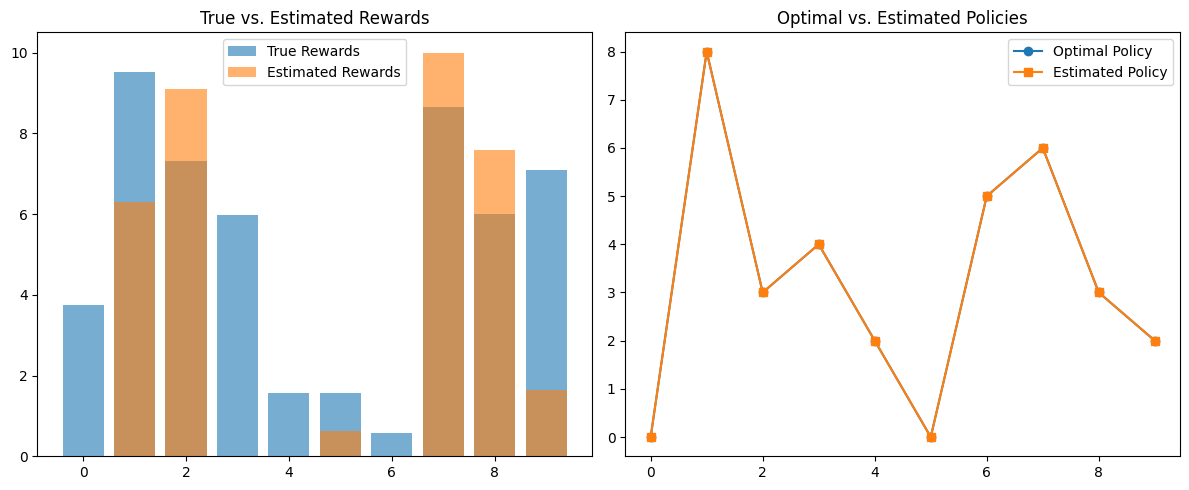

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
from scipy.optimize import linprog

def finite_lp_irl(num_states, num_actions, transition_probabilities, discount_factor, max_reward, optimal_policy, regularization=0.0):
    P_opt = np.vstack([transition_probabilities[s, :, optimal_policy[s]] for s in range(num_states)])
    inv_matrix = inv(np.eye(num_states) - discount_factor * P_opt)

    def drop_in_value(action, state):
        delta_p = P_opt[state, :] - transition_probabilities[state, :, action]
        return delta_p @ inv_matrix

    num_variables = num_states * 2
    c = np.concatenate([-np.ones(num_states), regularization * np.ones(num_states)])
    A_ub, b_ub = [], []

    for s in range(num_states):
        for a in range(num_actions):
            if a != optimal_policy[s]:
                row = np.zeros(num_variables)
                row[s] = 1
                row[num_states:] = -drop_in_value(a, s)
                A_ub.append(row)
                b_ub.append(0)

    for s in range(num_states):
        for a in range(num_actions):
            row = np.zeros(num_variables)
            row[num_states:] = -drop_in_value(a, s)
            A_ub.append(row)
            b_ub.append(0)

    for s in range(num_states):
        row = np.zeros(num_variables)
        row[num_states + s] = 1
        A_ub.append(row)
        b_ub.append(max_reward)

    bounds = [(0, None)] * num_variables
    res = linprog(c, A_ub=np.array(A_ub), b_ub=np.array(b_ub), bounds=bounds, method='highs')

    if not res.success:
        raise ValueError("Optimization failed: " + res.message)

    z_est, R_est = res.x[:num_states], np.clip(res.x[num_states:], None, max_reward)
    V_est = inv_matrix @ R_est
    return R_est, V_est

def generate_random_mdp(num_states, num_actions, max_reward):
    R_true = np.random.uniform(0, max_reward, size=num_states)
    Pssa = np.zeros((num_states, num_states, num_actions))
    for s in range(num_states):
        for a in range(num_actions):
            probabilities = np.random.rand(num_states)
            probabilities /= probabilities.sum()
            Pssa[s, :, a] = probabilities
    return R_true, Pssa

def value_iteration(num_states, num_actions, rewards, transition_probabilities, discount_factor, epsilon=1e-6, max_iterations=1000):
    V, policy = np.zeros(num_states), np.zeros(num_states, dtype=int)
    for _ in range(max_iterations):
        V_prev, Q = V.copy(), np.zeros((num_states, num_actions))
        for s in range(num_states):
            for a in range(num_actions):
                Q[s, a] = rewards[s] + discount_factor * transition_probabilities[s, :, a] @ V_prev
        V, policy = np.max(Q, axis=1), np.argmax(Q, axis=1)
        if np.max(np.abs(V - V_prev)) < epsilon:
            break
    return V, policy

num_states, num_actions, discount_factor, max_reward, regularization = 10, 10, 0.9, 10.0, 0.1
np.random.seed(42)

R_true, Pssa = generate_random_mdp(num_states, num_actions, max_reward)
V_opt, policy_opt = value_iteration(num_states, num_actions, R_true, Pssa, discount_factor)
R_est, V_est = finite_lp_irl(num_states, num_actions, Pssa, discount_factor, max_reward, policy_opt, regularization)
V_est_opt, policy_est = value_iteration(num_states, num_actions, R_est, Pssa, discount_factor)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(num_states), R_true, alpha=0.6, label='True Rewards')
plt.bar(range(num_states), R_est, alpha=0.6, label='Estimated Rewards')
plt.title('True vs. Estimated Rewards')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_states), policy_opt, 'o-', label='Optimal Policy')
plt.plot(range(num_states), policy_est, 's-', label='Estimated Policy')
plt.title('Optimal vs. Estimated Policies')
plt.legend()

plt.tight_layout()
plt.show()

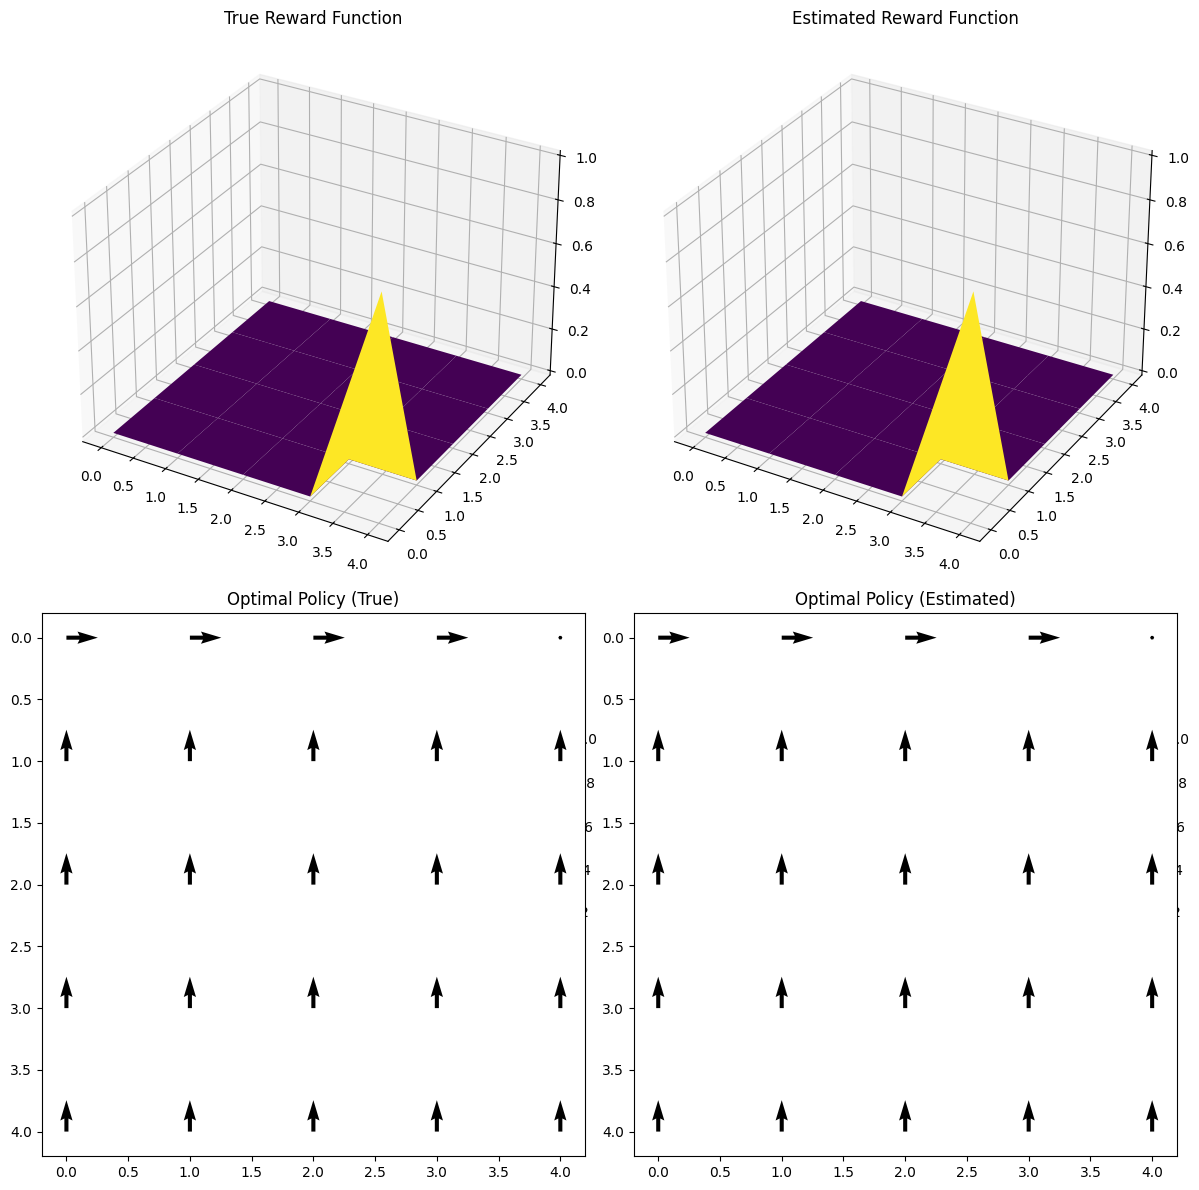

In [5]:
import numpy as np
from scipy.linalg import inv
from scipy.optimize import linprog
import matplotlib.pyplot as plt

def finite_lp_irl(num_states, num_actions, transition_probabilities, discount_factor, max_reward, optimal_policy, regularization=0.0):
    P_opt = np.vstack([transition_probabilities[s, :, optimal_policy[s]] for s in range(num_states)])
    inv_matrix = inv(np.eye(num_states) - discount_factor * P_opt)

    def drop_in_value(action, state):
        delta_p = P_opt[state, :] - transition_probabilities[state, :, action]
        return delta_p @ inv_matrix

    num_variables = num_states * 2
    c = np.concatenate([-np.ones(num_states), regularization * np.ones(num_states)])
    A_ub, b_ub = [], []

    for s in range(num_states):
        for a in range(num_actions):
            if a != optimal_policy[s]:
                row = np.zeros(num_variables)
                row[s] = 1
                row[num_states:] = -drop_in_value(a, s)
                A_ub.append(row)
                b_ub.append(0)

    for s in range(num_states):
        for a in range(num_actions):
            row = np.zeros(num_variables)
            row[num_states:] = -drop_in_value(a, s)
            A_ub.append(row)
            b_ub.append(0)

    for s in range(num_states):
        row = np.zeros(num_variables)
        row[num_states + s] = 1
        A_ub.append(row)
        b_ub.append(max_reward)

    bounds = [(0, None)] * num_variables
    res = linprog(c, A_ub=np.array(A_ub), b_ub=np.array(b_ub), bounds=bounds, method='highs')

    if not res.success:
        raise ValueError("Optimization failed: " + res.message)

    z_est, R_est = res.x[:num_states], np.clip(res.x[num_states:], None, max_reward)
    V_est = inv_matrix @ R_est
    return R_est, V_est

def value_iteration(num_states, num_actions, rewards, transition_probabilities, discount_factor, epsilon=1e-6, max_iterations=1000):
    V, policy = np.zeros(num_states), np.zeros(num_states, dtype=int)
    for _ in range(max_iterations):
        V_prev, Q = V.copy(), np.zeros((num_states, num_actions))
        for s in range(num_states):
            for a in range(num_actions):
                Q[s, a] = rewards[s] + discount_factor * transition_probabilities[s, :, a] @ V_prev
        V, policy = np.max(Q, axis=1), np.argmax(Q, axis=1)
        if np.max(np.abs(V - V_prev)) < epsilon:
            break
    return V, policy

grid_size, N, K, gamma, Rmax, lp_lambda = 5, 25, 5, 0.9, 1.0, 1
actions, P, noise_prob = ['up', 'down', 'left', 'right', 'stay'], np.zeros((N, N, K)), 0.3

for s in range(N):
    x, y = divmod(s, grid_size)
    for a_idx, action in enumerate(actions):
        next_x, next_y = x + (action == 'down') - (action == 'up'), y + (action == 'right') - (action == 'left')
        next_s = s if not (0 <= next_x < grid_size and 0 <= next_y < grid_size) else next_x * grid_size + next_y
        for noise_action in range(K):
            next_x_noise, next_y_noise = x + (noise_action == 1) - (noise_action == 0), y + (noise_action == 3) - (noise_action == 2)
            next_s_noise = s if not (0 <= next_x_noise < grid_size and 0 <= next_y_noise < grid_size) else next_x_noise * grid_size + next_y_noise
            P[s, next_s if noise_action == a_idx else next_s_noise, noise_action] = 1.0 - noise_prob if noise_action == a_idx else noise_prob / (K - 1)

true_R = np.zeros(N)
true_R[grid_size - 1] = 1.0

V_opt, opt_pi = value_iteration(N, K, true_R, P, gamma)
estimated_R, V_est = finite_lp_irl(N, K, P, gamma, Rmax, opt_pi, lp_lambda)
_, est_pi = value_iteration(N, K, estimated_R, P, gamma)

true_R_grid, estimated_R_grid = true_R.reshape(grid_size, grid_size), estimated_R.reshape(grid_size, grid_size)
action_to_vector = {0: (0, 1), 1: (0, -1), 2: (-1, 0), 3: (1, 0), 4: (0, 0)}
U_true, V_true, U_estimated, V_estimated = np.zeros((grid_size, grid_size)), np.zeros((grid_size, grid_size)), np.zeros((grid_size, grid_size)), np.zeros((grid_size, grid_size))

for s in range(N):
    x, y = divmod(s, grid_size)
    U_true[x, y], V_true[x, y] = action_to_vector[opt_pi[s]]
    U_estimated[x, y], V_estimated[x, y] = action_to_vector[est_pi[s]]

X, Y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})
axs[0, 0].plot_surface(X, Y, true_R_grid, cmap='viridis')
axs[0, 0].set_title('True Reward Function')
axs[0, 1].plot_surface(X, Y, estimated_R_grid, cmap='viridis')
axs[0, 1].set_title('Estimated Reward Function')

ax3 = fig.add_subplot(2, 2, 3)
ax3.quiver(X, Y, U_true, V_true)
ax3.set_title('Optimal Policy (True)')
ax3.set_aspect('equal')
ax3.invert_yaxis()

ax4 = fig.add_subplot(2, 2, 4)
ax4.quiver(X, Y, U_estimated, V_estimated)
ax4.set_title('Optimal Policy (Estimated)')
ax4.set_aspect('equal')
ax4.invert_yaxis()

plt.tight_layout()
plt.show()